In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statistics 

#displaying all rows
pd.set_option('display.max_rows', None)
#setting decimals to three places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
##import data
data = pd.read_csv('fatal-police-shootings-data.csv')
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.000,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.000,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.000,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.000,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.000,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [3]:
data.shape

(5879, 17)

In [4]:
#looking at min and max date 
print(data.date.min())
print(data.date.max())

2015-01-02
2020-12-13


In [5]:
#remove unecessary columsn
data.drop(['name', 'city', 'state', 'id', 'date', 'longitude', 'latitude',
           'is_geocoding_exact'], axis=1, inplace = True)

In [6]:
#create categorical category for age 
bins = [0, 2, 18, 35, 65, np.inf]
names = ['<2', '2-18', '18-35', '35-65', '65+']

data['AgeRange'] = pd.cut(data['age'], bins, labels=names)

In [7]:
#convert to object type
data.AgeRange = data.AgeRange.astype('object')

#remove age columns
data.drop('age', axis = 1, inplace = True)

#convert to object
data.signs_of_mental_illness = data.signs_of_mental_illness.astype('object')
data.body_camera = data.body_camera.astype('object')

In [8]:
data.dtypes

manner_of_death            object
armed                      object
gender                     object
race                       object
signs_of_mental_illness    object
threat_level               object
flee                       object
body_camera                object
AgeRange                   object
dtype: object

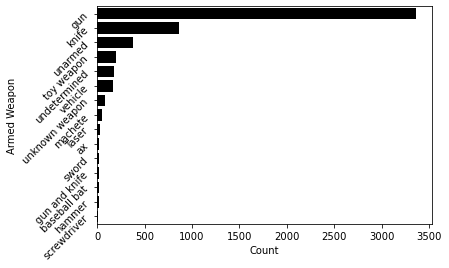

In [9]:
#looking at number 
armed_counts = pd.DataFrame(data.armed.value_counts()).head(15).reset_index()
armed_counts


plt.figure()
ax = sns.barplot(x = 'armed', y='index', data=armed_counts, orientation = 'horizontal', color = 'black')
ax.set(ylabel='Armed Weapon', xlabel='Count')
plt.yticks(rotation=45) 
plt.show()

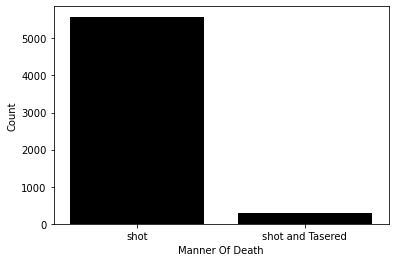

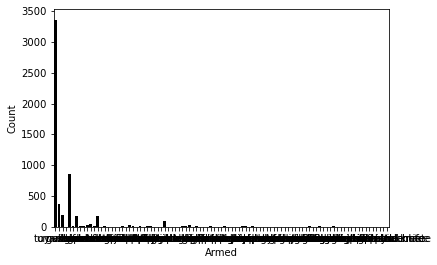

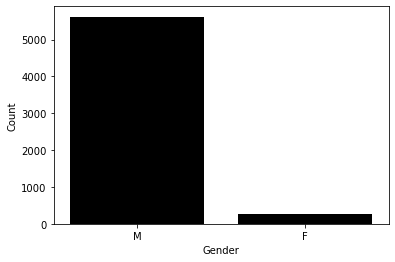

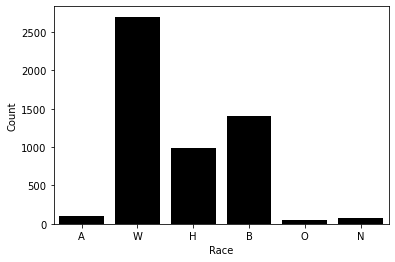

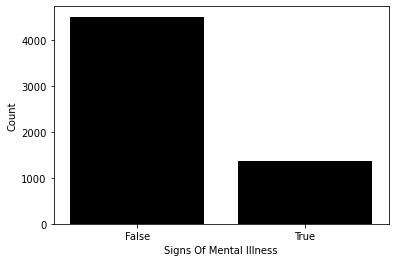

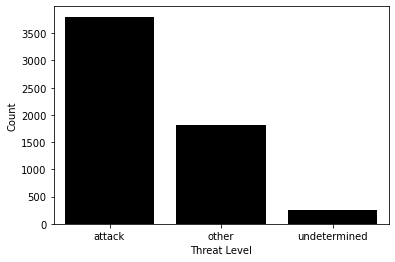

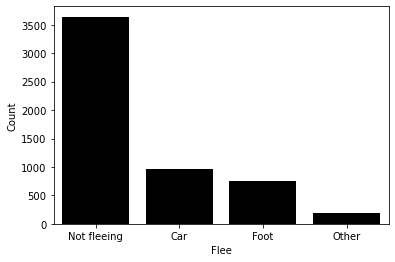

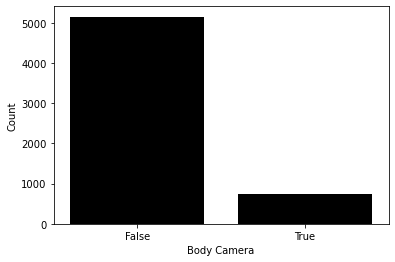

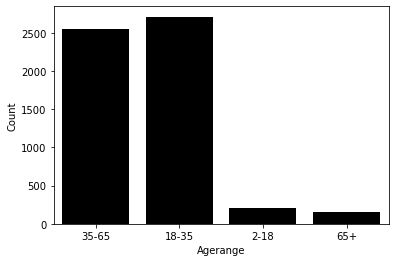

In [10]:
#looking at distribution of levels for each variable
for i, col in enumerate(data.columns):
    plt.figure(i)
    ax = sns.countplot(x=col, data=data, color = 'black')
    title = col.replace('_', ' ').title()
    ax.set(xlabel= title , ylabel='Count')
    

### KMeans

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [12]:
#checking for null values 
data.isnull().sum() / len(data) * 100

manner_of_death           0.000
armed                     3.606
gender                    0.017
race                      9.542
signs_of_mental_illness   0.000
threat_level              0.000
flee                      5.477
body_camera               0.000
AgeRange                  4.389
dtype: float64

In [13]:
#drop rows with na
data.dropna(inplace = True)
data.shape

(4759, 9)

In [14]:
##convert categorial variables to dummy vars to use kmeans algotithm 
data = pd.get_dummies(data=data, columns=['manner_of_death', 'armed', 'gender', 'race', 'signs_of_mental_illness', 
                                   'threat_level', 'flee', 'body_camera', 'AgeRange'])

In [15]:
data.head(2)

,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Airsoft pistol,armed_BB gun,armed_BB gun and vehicle,armed_Taser,armed_air conditioner,armed_air pistol,armed_ax,armed_barstool,...,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True,AgeRange_18-35,AgeRange_2-18,AgeRange_35-65,AgeRange_65+
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [16]:
from sklearn.decomposition import PCA

##pca to reduce dimensions 
pca=PCA()
pca.fit(data)

PCA()

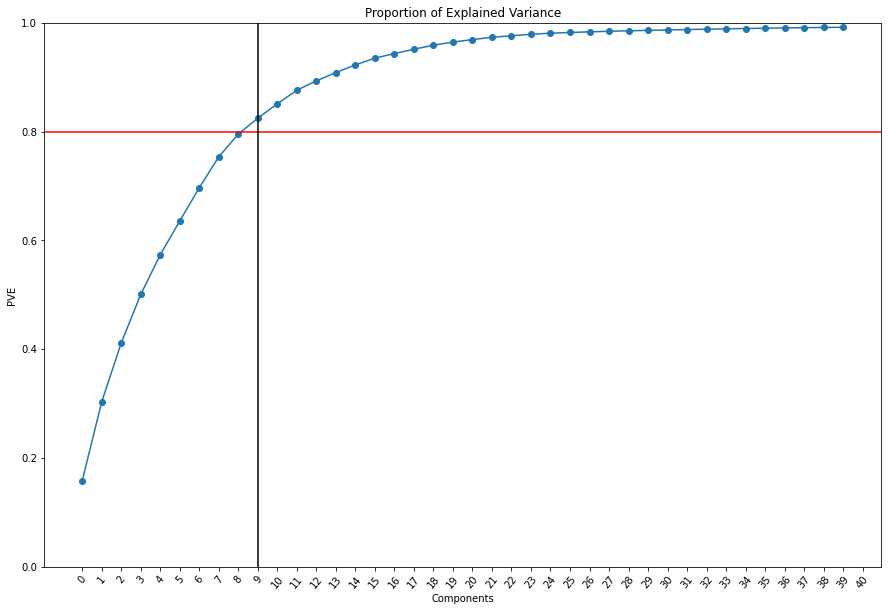

In [17]:
#plotting cumulative explained variance for first 40 components
plt.figure(figsize=(15,10))
plt.plot(pca.explained_variance_ratio_[:40].cumsum(),marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,1)
plt.xticks(np.arange(41))
plt.xticks(rotation='50')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.axvline(x = 9, color = 'black')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title("Proportion of Explained Variance")
plt.show()

In [18]:
##pca to reduce dimensions 
pca=PCA(n_components = 9)
pca.fit(data)

PCA(n_components=9)

In [19]:
pca_scores = pd.DataFrame(pca.fit_transform(data))

In [20]:
pca_scores.shape

(4759, 9)

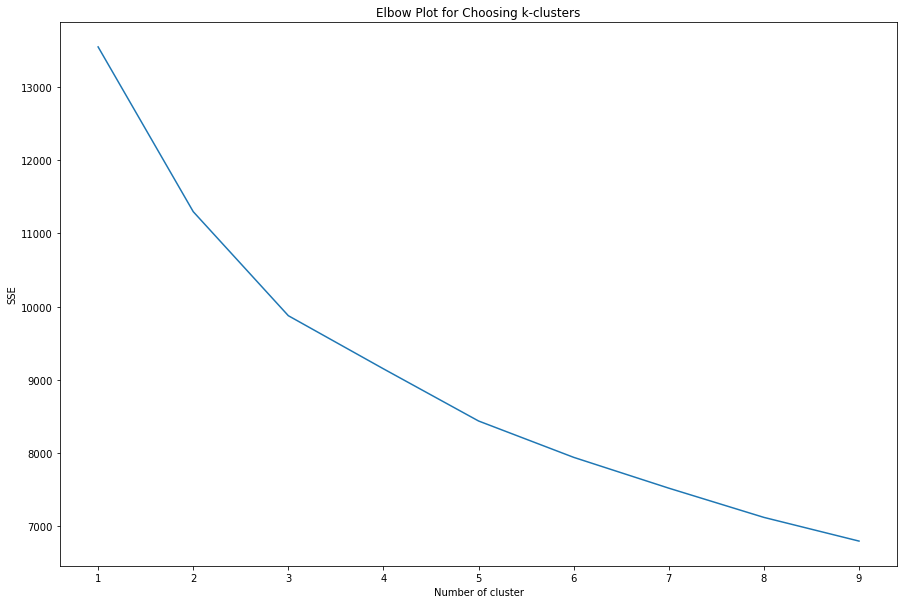

In [21]:
#cluster plot to find correct number of clusters 
kmeans_SSE = list()
for k in range(1,10):
    km = KMeans(n_clusters=k, init='random', random_state=0)
    km_clusters = km.fit_predict(pca_scores)
    to_append = km.inertia_
    kmeans_SSE.append(to_append)

plt.figure(figsize=(15,10))
plt.plot(range(1, 10), kmeans_SSE)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Elbow Plot for Choosing k-clusters")
plt.show()

In [22]:
km = KMeans(n_clusters=3, init='random', random_state=0)
km_clusters = km.fit_predict(pca_scores)

In [23]:
#adding cluster to pca data
pca_scores['Cluster'] = km_clusters
pca_scores.head(3)

,0,1,2,3,4,5,6,7,8,Cluster
0,0.813,-0.565,0.508,0.769,0.461,-0.246,-0.463,0.200,-0.024,1
1,0.604,-0.988,-0.258,-0.083,-0.399,0.181,-0.027,-0.016,0.059,1
2,-0.350,1.428,-0.207,0.056,-0.771,-0.475,0.005,0.474,0.060,2


In [24]:
#convert cluster to category
pca_scores.Cluster = pca_scores.Cluster.astype('category')
pca_scores.shape

(4759, 10)

In [25]:
#change column types
cols = list(data.select_dtypes('uint8'))
data[cols] = data.select_dtypes('uint8').astype('int64')

In [26]:
#combine original data and pca scores
pca_kmeans_data = pd.concat([data.reset_index(), pca_scores], axis = 1)

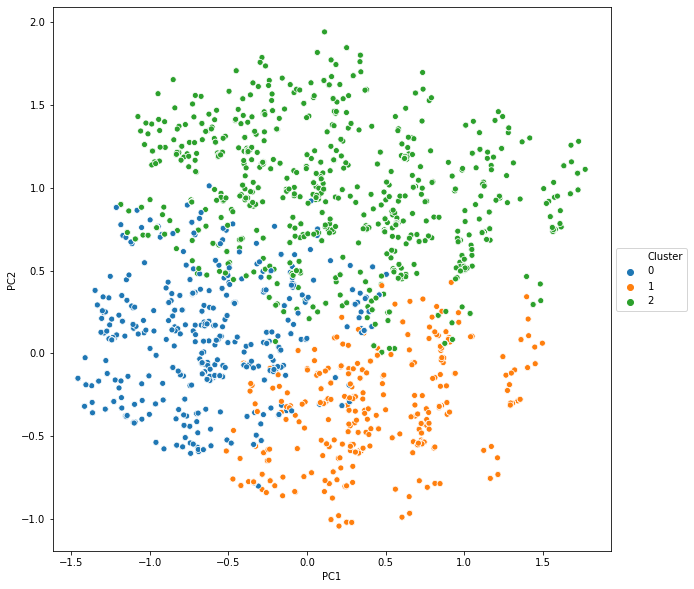

In [27]:
#create plot to look at clusters 
import seaborn as sns


plt.figure(figsize = (10, 10))
g = sns.scatterplot(pca_kmeans_data[0], pca_kmeans_data[1], hue = pca_scores.Cluster)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
g.set(xlabel='PC1', ylabel='PC2')

plt.show()

## Assocation Analysis 


In [28]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [29]:
#max column width to look at everyting that is in the row
pd.set_option('display.max_colwidth', None) 

#run apriori algo to look at frequent itemsets with highest support
frequent_itemsets = apriori(data, min_support=0.5, use_colnames=True)
frequent_itemsets.sort_values('support', ascending = False).head(5)

,support,itemsets
2,0.951,(gender_M)
0,0.947,(manner_of_death_shot)
9,0.900,"(manner_of_death_shot, gender_M)"
7,0.868,(body_camera_False)
19,0.825,"(body_camera_False, gender_M)"


In [30]:
#look at itemsets that contain someone being shot
frequent_itemsets[frequent_itemsets['itemsets'].astype(str).str.contains('shot')]

,support,itemsets
0,0.947,(manner_of_death_shot)
8,0.584,"(armed_gun, manner_of_death_shot)"
9,0.900,"(manner_of_death_shot, gender_M)"
10,0.722,"(manner_of_death_shot, signs_of_mental_illness_False)"
11,0.635,"(threat_level_attack, manner_of_death_shot)"
12,0.627,"(manner_of_death_shot, flee_Not fleeing)"
13,0.825,"(body_camera_False, manner_of_death_shot)"
24,0.562,"(armed_gun, manner_of_death_shot, gender_M)"
25,0.517,"(armed_gun, body_camera_False, manner_of_death_shot)"
26,0.690,"(manner_of_death_shot, gender_M, signs_of_mental_illness_False)"


In [31]:
#generate association rules
rules1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(armed_gun),(manner_of_death_shot),0.592,0.947,0.584,0.987,1.042,0.023,3.925
1,(manner_of_death_shot),(armed_gun),0.947,0.592,0.584,0.617,1.042,0.023,1.064
2,(manner_of_death_shot),(gender_M),0.947,0.951,0.900,0.950,0.999,-0.001,0.981
3,(gender_M),(manner_of_death_shot),0.951,0.947,0.900,0.946,0.999,-0.001,0.982
4,(manner_of_death_shot),(signs_of_mental_illness_False),0.947,0.757,0.722,0.762,1.007,0.005,1.022
5,(signs_of_mental_illness_False),(manner_of_death_shot),0.757,0.947,0.722,0.954,1.007,0.005,1.142
6,(threat_level_attack),(manner_of_death_shot),0.661,0.947,0.635,0.960,1.014,0.009,1.334
7,(manner_of_death_shot),(threat_level_attack),0.947,0.661,0.635,0.671,1.014,0.009,1.028
8,(manner_of_death_shot),(flee_Not fleeing),0.947,0.668,0.627,0.663,0.991,-0.005,0.983
9,(flee_Not fleeing),(manner_of_death_shot),0.668,0.947,0.627,0.939,0.991,-0.005,0.868


In [32]:
#look at rules that result in someone being shot
rules1[rules1['consequents'].astype(str).str.contains('shot')].sort_values('confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(armed_gun, body_camera_False)",(manner_of_death_shot),0.524,0.947,0.517,0.988,1.043,0.021,4.257
0,(armed_gun),(manner_of_death_shot),0.592,0.947,0.584,0.987,1.042,0.023,3.925
32,"(armed_gun, gender_M)",(manner_of_death_shot),0.570,0.947,0.562,0.986,1.041,0.022,3.779
70,"(body_camera_False, threat_level_attack)",(manner_of_death_shot),0.584,0.947,0.562,0.962,1.016,0.009,1.401
115,"(threat_level_attack, body_camera_False, gender_M)",(manner_of_death_shot),0.557,0.947,0.535,0.961,1.015,0.008,1.350
6,(threat_level_attack),(manner_of_death_shot),0.661,0.947,0.635,0.960,1.014,0.009,1.334
46,"(threat_level_attack, gender_M)",(manner_of_death_shot),0.632,0.947,0.606,0.959,1.012,0.007,1.285
64,"(body_camera_False, signs_of_mental_illness_False)",(manner_of_death_shot),0.665,0.947,0.636,0.956,1.010,0.006,1.214
101,"(body_camera_False, signs_of_mental_illness_False, gender_M)",(manner_of_death_shot),0.635,0.947,0.607,0.955,1.009,0.005,1.186
5,(signs_of_mental_illness_False),(manner_of_death_shot),0.757,0.947,0.722,0.954,1.007,0.005,1.142
